In [1]:
# code here copied from the Udacity course material

import numpy as np
import cv2
import time
import matplotlib as mpl
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

from mpl_toolkits.mplot3d import Axes3D
from functools import partial


import dill as pickle

from tqdm import tqdm
import asyncio

from utils import *
from features import *
from boxes import *
from images import *
from detection import *
from search import *

# Import everything needed to edit/save/watch video clips
from moviepy.editor import ImageSequenceClip, VideoFileClip
from IPython.display import HTML

%matplotlib inline   

In [2]:
%load_ext autoreload
%autoreload 2

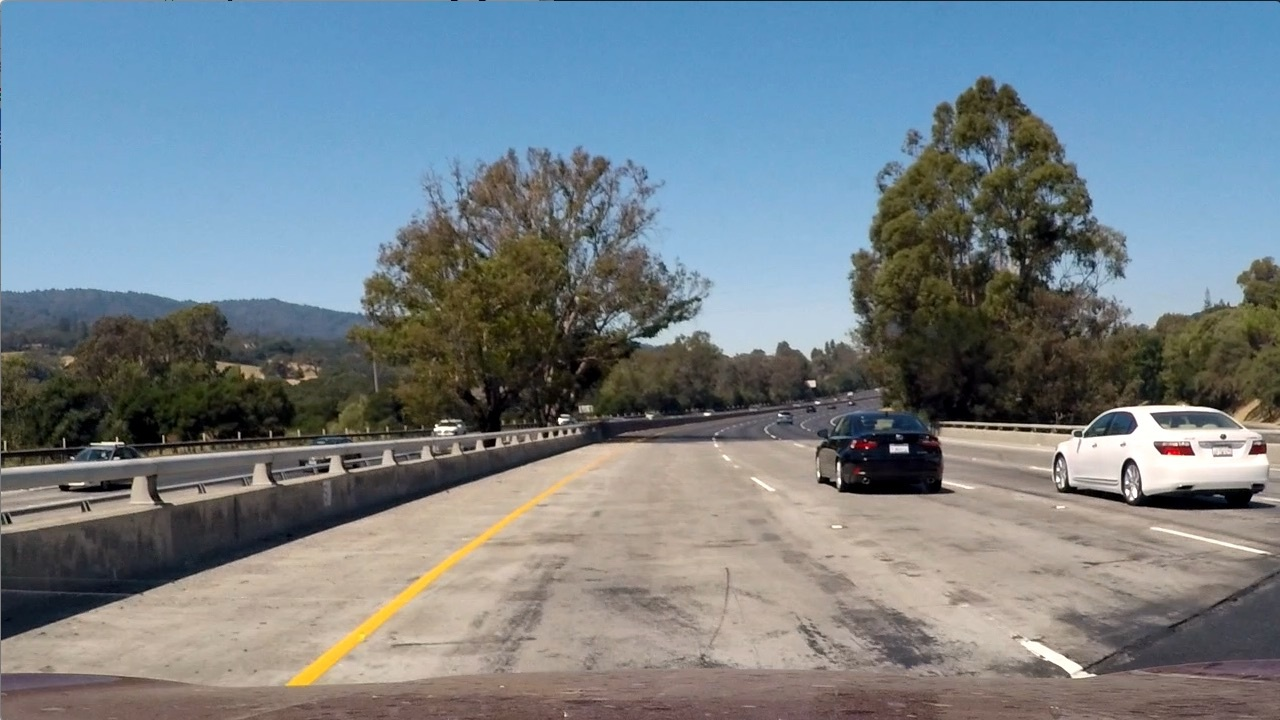

In [3]:
images, files = load_test_images()
arr2img(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))
#arr2img(images[0][1])
#plt.imshow(images[0][1])

 97%|█████████▋| 38/39 [00:00<00:00, 206.88it/s]


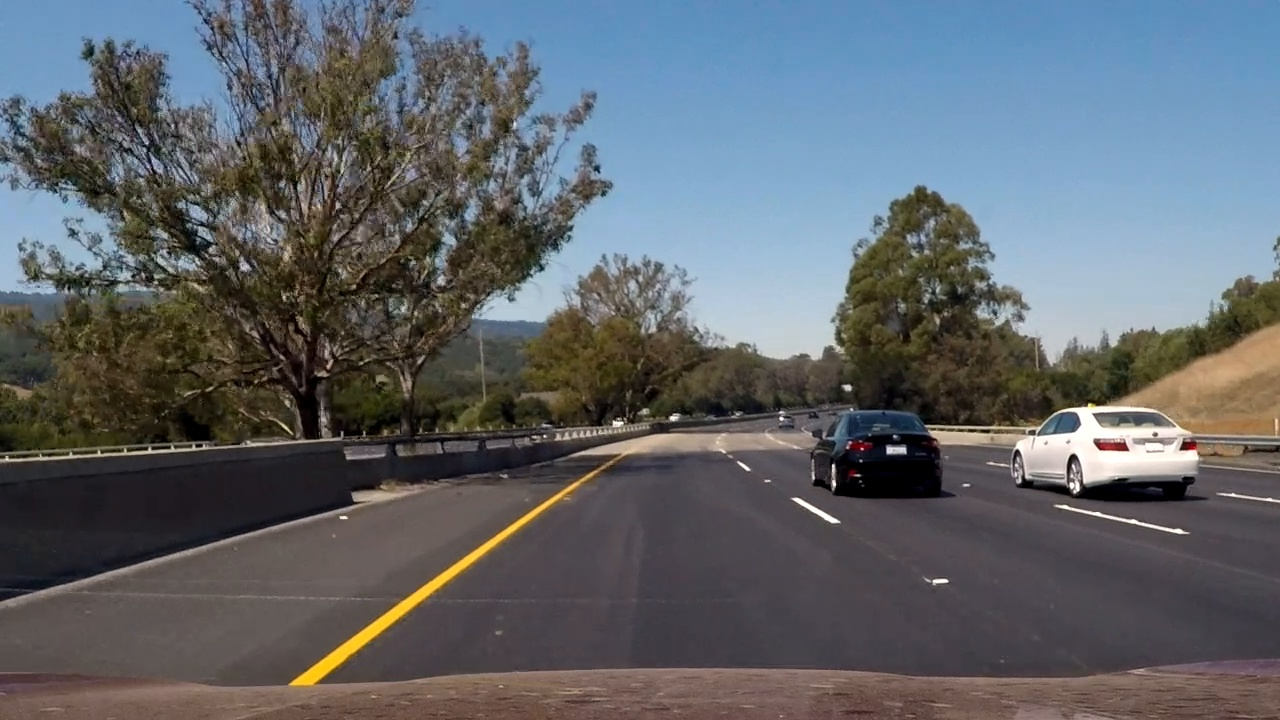

In [4]:
vimages, vframes = load_test_video()
arr2img(cv2.cvtColor(vimages[5], cv2.COLOR_BGR2RGB))

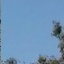

In [5]:
images, files = load_images()
arr2img(cv2.cvtColor(images[0],cv2.COLOR_BGR2RGB))

In [6]:
car_images, not_car_images = load_car_not_car_images()

var/non-vehicles/Extras (5068, 64, 64, 3) 5068
var/non-vehicles/GTI (3900, 64, 64, 3) 3900
var/vehicles/GTI_Far (834, 64, 64, 3) 834
var/vehicles/GTI_Left (909, 64, 64, 3) 909
var/vehicles/GTI_MiddleClose (419, 64, 64, 3) 419
var/vehicles/GTI_Right (664, 64, 64, 3) 664
var/vehicles/KITTI_extracted (5966, 64, 64, 3) 5966


In [7]:
len(car_images)

8792

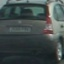

In [8]:
arr2img(cv2.cvtColor(car_images[900],cv2.COLOR_BGR2RGB))

[ 0.00616697  0.02155275  0.01058623 ...,  0.01058104  0.00178664
  0.00252669]


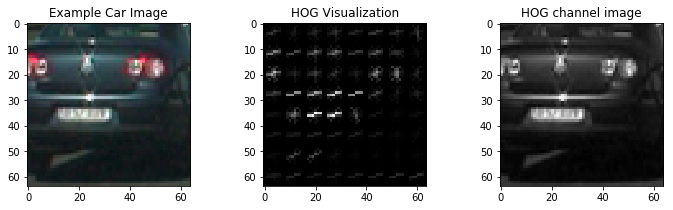

In [9]:
def test_hog(cars, ind, orient = 9, pix_per_cell =8, cell_per_block = 2):
    
    image = cars[ind]
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Call our function with vis=True to see an image output
#     features, hog_image = get_hog_features(gray, orient, 
#                         pix_per_cell, cell_per_block, 
#                         vis=True, feature_vec=False)

    hif = HogImageFeatures(gray, orient, pix_per_cell, cell_per_block)
    hifw=hif.window_hog_features(((0,0),(64,64)))
    print(hifw)
    #assert (hif.features.values == hifw.features.values).all()
    #print(hif.features)
    # Plot the examples
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Example Car Image')
    plt.subplot(132)
    plt.imshow(hif.hog_image, cmap='gray')
    plt.title('HOG Visualization')
    plt.subplot(133)
    plt.imshow(hif.image, cmap='gray')
    plt.title('HOG channel image')
    
ind = np.random.randint(0, len(car_images))
test_hog(car_images, ind)

<Container object of 96 artists>

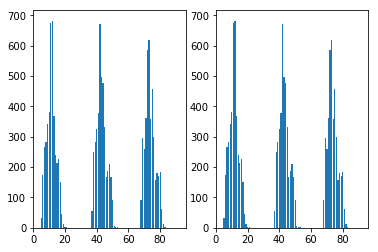

In [10]:
image=car_images[4]
chf =  ColorHistFeatures(image) # should select channel 0
values=chf.values

hist1, hist2, hist3, bin_centers, features = ColorHistFeatures.color_hist(image)

assert (values == features).all()
# full colour test
fig = plt.figure()
plt.subplot(121)
plt.xlim(0,chf.nbins*chf.color_channels)
plt.bar(np.arange(len(values)),values)
plt.subplot(122)
plt.xlim(0,chf.nbins*chf.color_channels)
plt.bar(np.arange(len(features)),features)

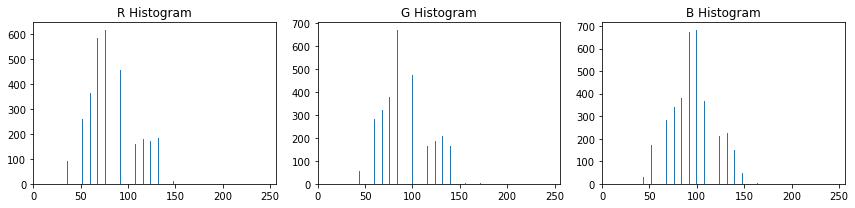

In [11]:
image=cv2.cvtColor(car_images[4], cv2.COLOR_BGR2RGB)
rh, gh, bh, bincen, feature_vec = ColorHistFeatures.color_hist(image, nbins=32, bins_range=(0, 256))

fig = plt.figure(figsize=(12,3))
plt.subplot(131)
plt.bar(bincen, rh[0])
plt.xlim(0, 256)
plt.title('R Histogram')
plt.subplot(132)
plt.bar(bincen, gh[0])
plt.xlim(0, 256)
plt.title('G Histogram')
plt.subplot(133)
plt.bar(bincen, bh[0])
plt.xlim(0, 256)
plt.title('B Histogram')
fig.tight_layout()

In [12]:
# copied from udacity course material
def plot3d(pixels, colors_rgb,
        axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):
    """Plot pixels in 3D."""

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation

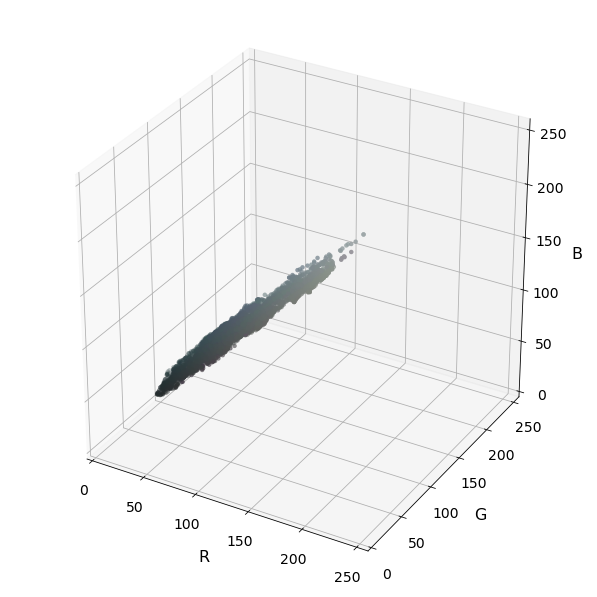

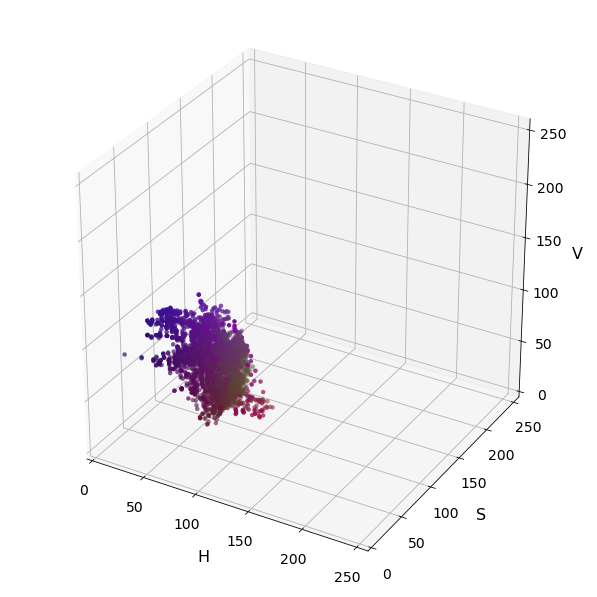

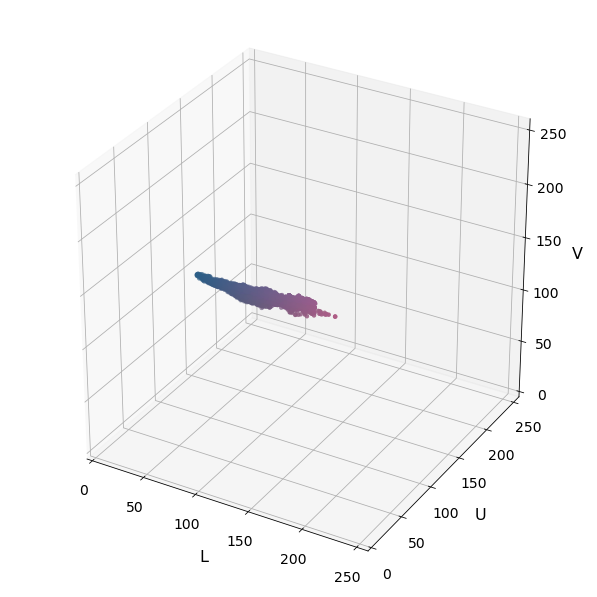

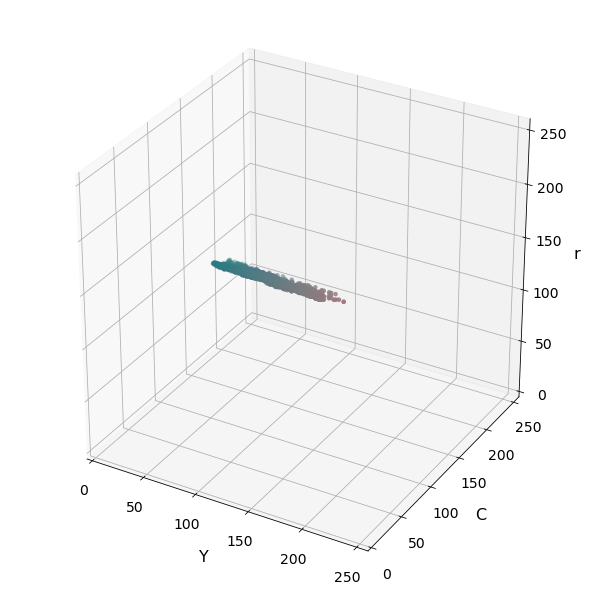

In [13]:
img=car_images[4]

# Select a small fraction of pixels to plot by subsampling it
scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_LUV = cv2.cvtColor(img_small, cv2.COLOR_BGR2LUV)
img_small_YCrCb = cv2.cvtColor(img_small, cv2.COLOR_BGR2YCrCb)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot and show
plot3d(img_small_RGB, img_small_rgb)
plot3d(img_small_HSV, img_small_HSV /255., axis_labels=list("HSV"))
plot3d(img_small_LUV, img_small_LUV /255., axis_labels=list("LUV"))
plot3d(img_small_YCrCb, img_small_YCrCb /255., axis_labels=list("YCrCb"))
plt.show()

[ 105.   91.  135. ...,    0.    0.    0.]


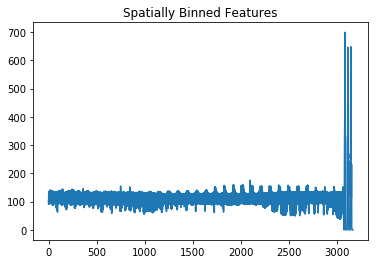

In [14]:
image=car_images[5]
#feature_vec = BinSpatialFeatures.bin_spatial(image, color_space='BGR', size=(32, 32))
chf = ColorHistFeatures(image,)    
bsf = BinSpatialFeatures(image, color_space='LUV', size=(32, 32))
feature_vec = bsf+chf
print(feature_vec)
# feature_vec = bsf.values

# Plot features
plt.plot(feature_vec)
plt.title('Spatially Binned Features')

Hog Classify
===

In [15]:
# sample_size = 10000
# cars = car_images[0:sample_size]
# notcars = not_car_images[0:sample_size]

cars = car_images
notcars = not_car_images

colorspace = 'YCrCb' # Can be BGR, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 0 # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_hog_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_hog_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
#X_scaler = StandardScaler(with_mean=True, with_std=True).fit(X)
X_scaler = RobustScaler().fit(X)
# X_scaler = MinMaxScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

100%|██████████| 8968/8968 [00:32<00:00, 277.31it/s]


65.81 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 1860


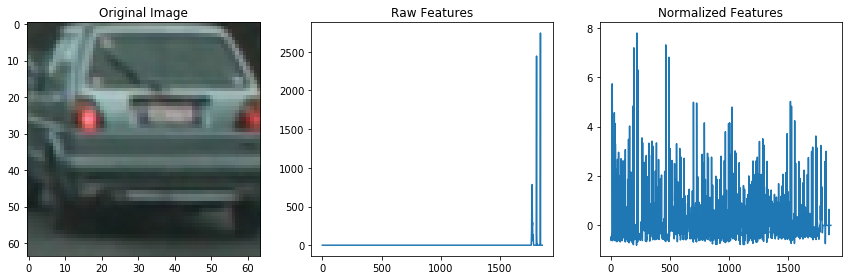

In [16]:
car_ind = np.random.randint(0, len(car_images))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(cv2.cvtColor(car_images[car_ind], cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.subplot(132)
plt.plot(X[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X[car_ind])
plt.title('Normalized Features')
fig.tight_layout()

In [17]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Train Accuracy of SVC = ', round(svc.score(X_train, y_train), 4))
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

5.77 Seconds to train SVC...
Train Accuracy of SVC =  0.9999
Test Accuracy of SVC =  0.9817
My SVC predicts:  [ 0.  1.  0.  0.  1.  0.  1.  0.  0.  1.]
For these 10 labels:  [ 0.  1.  1.  0.  1.  0.  1.  0.  0.  1.]
0.00305 Seconds to predict 10 labels with SVC


In [18]:
wb = WindowBoxes(height=image[0].shape[0], width=image[0].shape[1])
total=0
for size, windows in wb.window_boxes_dict.items():
    count=len(windows)
    total = total + count
    print("{} count {}".format(size, count))

print("total", total)

smallish count 413
small count 639
medium count 126
total 1178


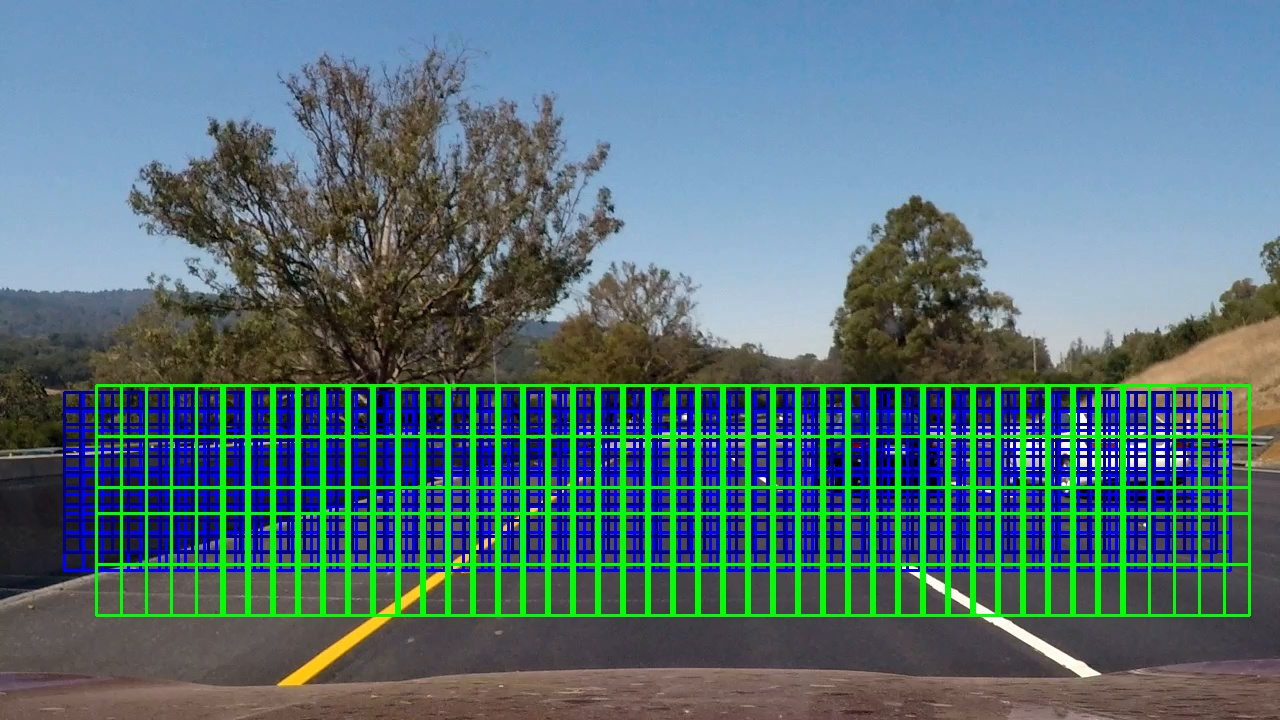

In [19]:
images, _ = load_test_images()
@interact
def window_test(images=fixed(vimages), i:(0,len(vimages)-1)=0, 
                all_shapes=True,
                shape:["small","smallish","medium","large","max"]="small"):    
    image=cv2.cvtColor(images[i],cv2.COLOR_BGR2RGB)
    height = image.shape[0]
    width = image.shape[1]
    wb = WindowBoxes(height, width)
    box_color=wb.box_colour_dict

    window_dict = wb.build_window_boxes(height, width, all_shapes, shape) 
    window_img=np.copy(image)
    for size, windows in window_dict.items():
        window_img = draw_boxes(window_img, windows, color=box_color[size], thick=2)   
    
    return arr2img(window_img)

In [20]:
# initialise an object to contain common parameters
color_space = 'YCrCb' # Can be BGR, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
hist_range = (0,256)
spatial_feat = False # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

    
search_params = SearchParams(color_space, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size,
                  hist_bins, hist_range, spatial_feat, hist_feat, hog_feat, svc, X_scaler)
print(search_params)

SearchParams(color_space='YCrCb', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0, spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256), spatial_feat=False, hist_feat=True, hog_feat=True, clf=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0), X_scaler=RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True))


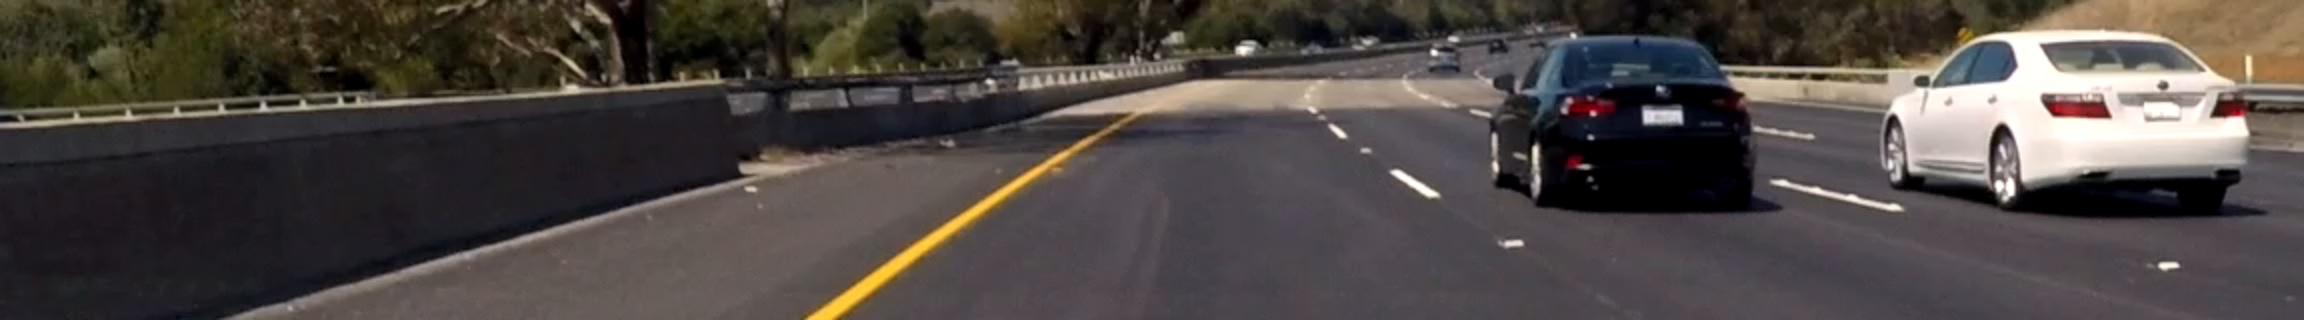

In [21]:
@interact
def camera_window_box_test(images=fixed(vimages), i:(0,len(vimages)-1)=0, shape:["small","smallish","medium","large","max"]="small"):
    camera_image=CameraImage(images[i])
    window_boxes=WindowBoxes(camera_image.height, camera_image.width)               

    img=CameraImage.slice_bounding_box_shape_resize_64x64(camera_image.image, window_boxes, shape)
    #print(window_boxes.bounding_box(shape), window_boxes.resize_64x64_ratio(shape), img.shape)
    return arr2img(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

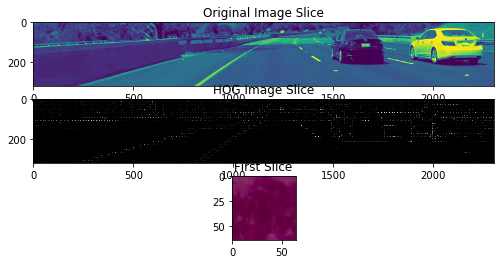

In [22]:
## initialise an object to contain common parameters
color_space = 'YCrCb' # Can be BGR, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
hist_range = (0,256)
spatial_feat = False # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

    
search_params = SearchParams(color_space, orient, pix_per_cell, cell_per_block, hog_channel, spatial_size,
                  hist_bins, hist_range, spatial_feat, hist_feat, hog_feat, svc, X_scaler)

@interact
def hog_slice_test(images=fixed(vimages), i:(0,len(vimages)-1)=0,
                   shape:["small","smallish","medium","large","max"]="small"):
    camera_image = CameraImage(images[i])
    window_boxes = WindowBoxes(camera_image.height, camera_image.width)
    image_slice = ImageSlice(camera_image, window_boxes, search_params, shape)
    image_windows = [wbs for wbs in image_slice.window_generator()]
    image = image_slice.image

    hog_image = image_slice.hog_image(0)
#     print(window_boxes.bounding_box(shape), window_boxes.resize_64x64_ratio(shape), image.shape)
  
    hog_features_list = image_slice.hog_features_list
#     print(len(hog_features_list))
#     print("hog_features_list[0].values.shape=",hog_features_list[0].values.shape)
#     print(image_slice.image.shape,hog_image.shape)
    #print(window_boxes.windows(shape))
#     print(image_windows)

#     for w in image_windows:
#         print("windows: %r slice_window %r hog: %r" % (w.bbox, w.bbox_slice,
#                                                        image_slice.window_hog_features(w.bbox_slice)))
    fig = plt.figure(figsize=(12,4))
    plt.subplot(311)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)[:,:,0])
    plt.title('Original Image Slice')
    plt.subplot(312)
    plt.imshow(hog_image, cmap='gray')
    plt.title('HOG Image Slice')
    plt.subplot(313)
    plt.imshow(hog_image, cmap='gray')
    plt.title('First Slice')
    plt.imshow(cv2.cvtColor(image_slice.slice_window(image_windows[0].bbox_slice), cv2.COLOR_LUV2RGB))         

In [23]:
# this is really slow when there are lots of windows - run with caution

@interact
def single_windows_features_test(images=fixed(images), i:(0,len(images)-1)=0,
                                 shape:["small","smallish","medium","large","max"]="max"):

    vehicle_detection = VehicleDetection(search_params,images[i].shape[0], images[i].shape[1])
    vehicle_detection.image = images[i]
    camera_image = vehicle_detection.camera_image
    window_boxes = vehicle_detection.window_boxes
    image_slice = ImageSlice(camera_image, window_boxes, search_params, shape)

    nboxes=len(window_boxes.window_boxes_dict[shape])
    fig = plt.figure(figsize=(10,nboxes*1.5))

    i = 0
    for wbs in image_slice.window_generator()[:10]:
        t=time.time()
        features = VehicleDetection.single_window_features(image_slice, wbs, search_params)
        t2=time.time()
#         print("{} {} detected {} features {} secs".format(wbs.bbox, wbs.bbox_slice,len(features),t2-t))
        #X=[features]
        scaled_features = search_params.X_scaler.transform(features.reshape(1,-1))
        t3=time.time()
#         print("feature scale time {}".format(t3-t2))

#         print("scaled_X {}".format(scaled_X))
        prediction = search_params.clf.predict(scaled_features)
        t4=time.time()
#         print("{} for {} total detection time: {} transform time: {} prediction time: {}".format(prediction,wbs.bbox_slice,t2-t,t3-t2,t4-t3))
        # plotting is slow
        plt.subplot(nboxes, 3, (i*3)+1)
        plt.imshow(image_slice.slice_window(wbs.bbox_slice))
        #plt.xticks([]), plt.yticks([])
        plt.subplot(nboxes, 3, (i*3)+2)
        plt.plot(features)
        plt.subplot(nboxes, 3, (i*3)+3)
        plt.plot(scaled_features[0])
        fig.tight_layout()
        i += 1

    plt.show

KeyError: 'max'

4 cars found


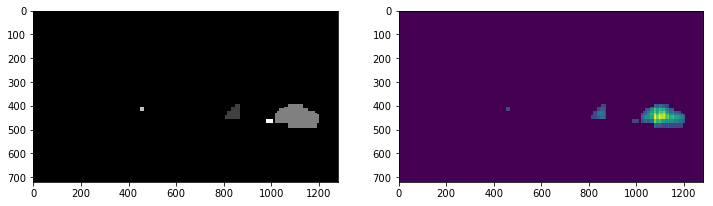

In [24]:
loop = asyncio.new_event_loop()
asyncio.set_event_loop(loop)

@interact
def hot_windows_test(images=fixed(vimages), i:(0,len(vimages)-1)=0):

    vehicle_detection = VehicleDetection(search_params,images[i].shape[0], images[i].shape[1], loop)
    vehicle_detection.image = images[i]
    #return arr2img(vehicle_detection.result)
    
    fig = plt.figure(figsize=(12,4))
    plt.subplot(121)
    labels = vehicle_detection.labels
    print(labels[1], 'cars found')
    plt.imshow(labels[0], cmap='gray')
    plt.subplot(122)
    heatmap = vehicle_detection.heatmap
    plt.imshow(heatmap)
    #sns.heatmap(heatmap)
    #sns.xticklabels = False
    plt.show
    
    #plt.imshow(heatmap)
    
#     return arr2img(vehicle_detection.result_decorated)
#     return arr2img(vehicle_detection.heatmap_decorated)
#    camera_image=CameraImage(images[i])
#    window_boxes=WindowBoxes(camera_image.height, camera_image.width)
#     image=camera_image.image_bottom
#     print(camera_image.image_bottom.shape)
#     print(camera_image.hog_features(search_params))
#     features,hog_image = camera_image.hog_channel_features(image[:,:,2],search_params,vis=True,feature_vec=True)
#     print(features.shape)
#     return arr2img(hog_image)
    #hot_windows=hot_windows_search(camera_image, window_boxes, search_params)
    #window_img = draw_boxes(camera_image.rgb, hot_windows, color=(0, 0, 255), thick=2)                    

#     image=CameraImage.slice_bounding_box_shape_resize_64x64(camera_image, window_boxes, shape)
#     features,hog_image = camera_image.hog_channel_features(image[:,:,2],search_params,vis=True,feature_vec=True)
#     print(window_boxes.bounding_box(shape), window_boxes.resize_64x64_ratio(shape), img.shape)
#     return arr2img(hog_image)

In [25]:
loop = asyncio.new_event_loop()
asyncio.set_event_loop(loop)

def detection_result_profile(images=vimages, i=10):

    vehicle_detection = VehicleDetection(search_params,images[i].shape[0], images[i].shape[1], loop)
    vehicle_detection.image = images[i]
    
    return arr2img(vehicle_detection.result)


In [26]:
%timeit detection_result_profile()

1 loop, best of 3: 1.51 s per loop


In [27]:
%prun detection_result_profile()